# Getting started using Flux


[Flux](https://fluxml.ai/) is a Deep Learning library written entirely in [Julia](https://julialang.org/). Flux's website states that it makes the easy things easy while remaining fully hackable. This makes Flux an ideal library to get started in Deep Learning because you can look under the hood and see how algorithms are implemented. Also, some members of the community say that in the future, Julia might have a more predominant role in Machine Learning (see [The Future of Machine Learning and why it looks a lot like Julia](https://towardsdatascience.com/the-future-of-machine-learning-and-why-it-looks-a-lot-like-julia-a0e26b51f6a6)).


In this post, we go through a simple linear regression example using Julia and Flux. To train a ML model in Flux, we need to perform the following four steps:

1. Get the data set.
2. Define the model.
3. Define the loss function.
4. Set an optimisation routine.
5. Train the model.

If you want to follow along, then make sure that you install Julia and Flux. Also, you can try both Julia and Flux wihout installing by using this [Colab notebook](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb) as a starting point. For a quick introduction to Julia, see [Learn Julia For Beginners](https://www.freecodecamp.org/news/learn-julia-programming-language/) and [Julia for Pythonistas](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_for_Pythonistas.ipynb).

Before going through the steps we listed above, we import the packages we need:

In [1]:
# Import Flux and Plots for visualizing the data
using Flux
using Flux: train!
using Plots

Besides importing Flux, we also use the package [Plots](https://docs.juliaplots.org/stable/) for creating visualisations in Julia. You can learn more about visualisation Julia in this [post](https://towardsdatascience.com/interactive-data-visualization-with-julia-and-pluto-notebooks-6fad6f3eca2).

## Step 1: Get the data set

For this example, we generate our own data but keep in mind that you can also use your own data when creating models with Flux. We create random data that has some linear relationship and add some noise to it.

In [37]:
# Generate random data with some weak linear relation
function generate_data(num_elems)
    X = rand(num_elems)
    y = 0.5X .+ rand(num_elems)
    return X, y
end

generate_data (generic function with 1 method)

In [38]:
# Set the number of data points
num_elems = 500

500

In [39]:
# Generate train and test data 
x_train, y_train = generate_data(num_elems)
x_test, y_test = generate_data(num_elems)

([0.3836056352696451, 0.6478992415603053, 0.9071249759962821, 0.9479282564948006, 0.2798652529019978, 0.6102171184153324, 0.09596132631385101, 0.6660488882066076, 0.088900564380755, 0.9447945517277412  …  0.2886308936975561, 0.15729856567038447, 0.7262120782983175, 0.6327738779738452, 0.1351479942787681, 0.4834875019513585, 0.7202842628539614, 0.5137510509651806, 0.7247422069789653, 0.6574521127501967], [0.857830036830477, 1.1251447635733478, 1.3882565776070122, 1.1896129830337017, 0.8373793123326244, 0.6896979333113807, 0.8794654848380079, 0.3446720405076892, 0.7549460457690121, 0.7491687614709202  …  0.7792591498026841, 0.7238729304939143, 1.125118484943863, 0.5108441264748381, 0.2353931217790326, 1.1802054250654415, 0.9585403118678618, 0.5579643502888982, 1.278562013380638, 1.1365329110569227])

Now, we plot the data to check its distribution.

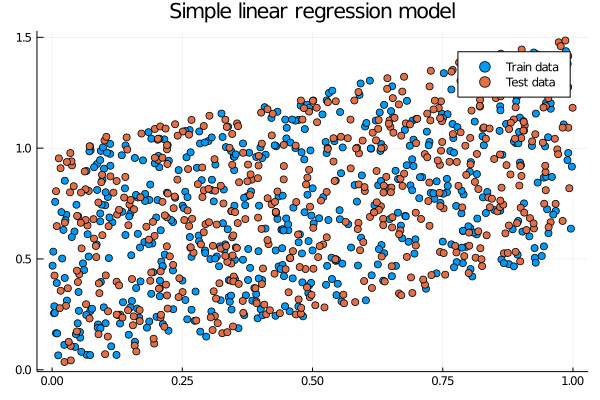

In [40]:
plot(x_train, y_train, title="Simple linear regression model", label="Train data", seriestype = :scatter)
plot!(x_test, y_test, label="Test data", seriestype = :scatter)

The train and test data have more or less the same distribution. Both data sets show a linear relationship.

Before moving on to the next step, we reshape our data so that we can pass it to the model we'll create using Flux. 

In [41]:
# Check the shape of the train data
size(x_train)

(500,)

The train data contains 500 elements. However, we need reshape it as a 1x500 array.

In [42]:
# Reshape the train data
reduce(hcat, x_train)

1×500 Array{Float64,2}:
 0.111328  0.316201  0.766586  0.00234181  …  0.996001  0.185439  0.460803

We applied the *hcat* function ([horizontal concatenation](https://riptutorial.com/julia-lang/example/25225/concatenation#undefined)) to our train data and used *reduce* (high order function) to obtain the correct shape. We create a function with the step above:

In [43]:
function reshape_data(X, y)
    X = reduce(hcat, X)
    y = reduce(hcat, y)
    return X, y    
end 

reshape_data (generic function with 1 method)

Now, we apply the function to all of the data and check the final shape.

In [44]:
x_train, y_train = reshape_data(x_train, y_train)

([0.1113281391307055 0.31620064159394845 … 0.1854387767953869 0.4608026433235288], [0.9744623760500601 0.511180422151496 … 0.566787268505568 1.129244340960365])

In [45]:
size(x_train)

(1, 500)

In [46]:
x_test, y_test = reshape_data(x_test, y_test)

([0.3836056352696451 0.6478992415603053 … 0.7247422069789653 0.6574521127501967], [0.857830036830477 1.1251447635733478 … 1.278562013380638 1.1365329110569227])

In [47]:
size(x_test)

(1, 500)

## Step 2: Define the model

We want to create a simple linear regression model $m(x) = W*x + b$. To define this type of model, we set a single neuron with no activation function. In Flux, we can use the [Dense function](https://fluxml.ai/Flux.jl/stable/models/layers/#Flux.Dense) to define our model:

In [48]:
model = Dense(1, 1)

Dense(1, 1)

Our model is initialized with random values for $W$ and $b$ (weights and biases). We need to train our model so we can find better values for the weights and biases. Also, we need to collect all of the parameters so we can access them during the training and updating of the parameters of our model.

In [49]:
ps = Flux.params(model)

Params([Float32[1.1341509], Float32[0.0]])

## Step 3: Define the loss function

We measure our model so we can determine how good our model is. Flux has a lot of ready to use [loss functions](https://fluxml.ai/Flux.jl/stable/models/losses/). In this example, we'll use MSE:

In [50]:
loss(x, y) = Flux.Losses.mse(model(x), y)

loss (generic function with 1 method)

## Step 4: Set an optimisation routine

Now, we set the optimization routine (optimiser) that we'll use to train our model. This optimiser will optimise the loss function (find the best value for the weights and biases that achieve the smallest loss).

For this example, we use the gradient descent algorithm but Flux offers [many routines](https://fluxml.ai/Flux.jl/stable/training/optimisers/).

In [51]:
# Use gradient descent
opt = Descent()

Descent(0.1)

In [52]:
# Define a predict function that outputs our model's result
predict(x) = model(x)

predict (generic function with 1 method)

Before we train our model, we compute the predictions and the current loss to compare with the final results.

In [53]:
pred_0 = predict(x_test)

1×500 Array{Float32,2}:
 0.435067  0.734816  1.02882  1.07509  …  0.582671  0.821967  0.74565

In [54]:
loss_0 = loss(predict(x_test), y_test)

0.14803291163706297

## Step 5: Train the model

Finally, we are ready to train our model. Before calling Flux's training routine, we need to zip the train data:

In [55]:
data = [(x_train, y_train)]

1-element Array{Tuple{Array{Float64,2},Array{Float64,2}},1}:
 ([0.1113281391307055 0.31620064159394845 … 0.1854387767953869 0.4608026433235288], [0.9744623760500601 0.511180422151496 … 0.566787268505568 1.129244340960365])

In Flux, we can execute one training step with the `train!` function:

In [56]:
train!(loss, ps, data, opt)

In [57]:
# Set the number of iterations (epochs)
n_epochs = 12

12

Or we can run the train! function inside a for loop:

In [58]:
# Run the train routine and output the loss
for epoch in 1:n_epochs
    train!(loss, ps, data, opt)
    println(loss(model(x_test), y_test))
end

0.13877398015615566
0.14634020369663664
0.15498140622455125
0.16276039617560173
0.16895430857000554
0.1734429804541386
0.17637677021205286
0.17800457770023226
0.17858874792644772
0.17836788138274282
0.17754335968123622
0.17627817389163825


**Note:** We can have more control of the training routine by using another approach. For more information on training in Flux, see [Training](https://fluxml.ai/Flux.jl/stable/training/training/). 

In [64]:
# Compute the final predictions
pred_1 = model(x_test)

1×500 Array{Float32,2}:
 0.989131  0.203169  0.521636  1.22012  …  1.37866  0.444732  0.721515

After training our model, we plot the results to see what our model's predictions look like. Note that since we reshaped our data, we need to transform it back to its original shape.

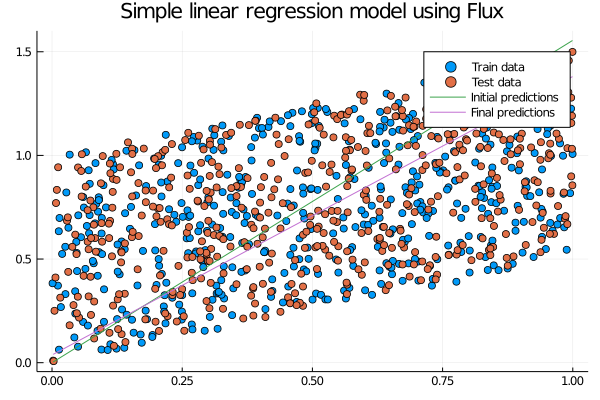

In [63]:
plot(x_train', y_train', title="Simple linear regression model using Flux", label="Train data", seriestype = :scatter)
plot!(x_test', y_test', label="Test data", seriestype = :scatter)
plot!(x_test', pred_0', label="Initial predictions")
plot!(x_test', pred_1', label="Final predictions")

The plot above shows both the model's initial predictions (random parameters) and the final ones (after training). We can see that the model improved very quickly after a few iterations. However, when training a model with real data things get more complicated and we need to use more complex training routines. 

## Full code

We can run the full script at once. First, create a file with extension `.jl` with the code below and then run it as `julia name-of-your-file.jl`. 

In [61]:
using Flux
using Flux: train!
using Plots

# Generate random data with some weak linear relation
function generate_data(num_elems)
    X = rand(num_elems)
    y = 0.5X .+ rand(num_elems)
    return X, y
end

function reshape_data(X, y)
    X = reduce(hcat, X)
    y = reduce(hcat, y)
    return X, y    
end 

# Set the number of data points
num_elems = 500

x_train, y_train = generate_data(num_elems)
x_test, y_test = generate_data(num_elems)

x_train, y_train = reshape_data(x_train, y_train)
x_test, y_test = reshape_data(x_test, y_test)

model = Dense(1, 1)
ps = Flux.params(model)
loss(x, y) = Flux.Losses.mse(model(x), y)
opt = Descent()

# Get predictions from our model
predict(x) = model(x)

# Compute initial predictions and loss
pred_0 = predict(x_test)
loss_0 = loss(predict(x_test), y_test)

println("Initial loss: $loss_0")

# Zip the train before so we can pass it to the training function
data = [(x_train, y_train)]
n_epochs = 15

for epoch in 1:n_epochs
    train!(loss, ps, data, opt)
    println("Epoch: $epoch, loss: ", loss(predict(x_test), y_test))
end

Initial loss: 0.5881015343985887
Epoch: 1, loss: 0.5203024965928137
Epoch: 2, loss: 0.47164930189943716
Epoch: 3, loss: 0.4353832910022624
Epoch: 4, loss: 0.4073565674351173
Epoch: 5, loss: 0.38495918931325107
Epoch: 6, loss: 0.3665080551334178
Epoch: 7, loss: 0.35089248221556046
Epoch: 8, loss: 0.33736342712075623
Epoch: 9, loss: 0.3254055939974467
Epoch: 10, loss: 0.31465832635734403
Epoch: 11, loss: 0.3048644706866289
Epoch: 12, loss: 0.2958386653221097
Epoch: 13, loss: 0.2874453887174569
Epoch: 14, loss: 0.2795838279143394
Epoch: 15, loss: 0.27217828976791464


## Final remarks

As you can see, it is very easy to create a simple model using Flux. However, Flux offers way more than that. We can create more complex models such as CNN's and RNN's. For more information on Flux and how you can use other examples as a starting point for your own projects see [Flux's docs](https://fluxml.ai/Flux.jl/stable/) and the [Model Zoo](https://github.com/FluxML/model-zoo/). 